In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

## 1. Подготовка данных

* проверить наличие пропусков и выбросов

In [2]:
test = pd.read_csv('../datasets/insurance_train.csv')
train = pd.read_csv('../datasets/insurance_test.csv')

In [3]:
print(train.shape, test.shape)

(1000, 7) (338, 7)


In [4]:
train.head()

,age,sex,bmi,children,smoker,region,charges
0,61,male,38.380,0,no,northwest,12950.07120
1,59,female,34.800,2,no,southwest,36910.60803
2,31,male,30.875,0,no,northeast,3857.75925
3,24,female,33.345,0,no,northwest,2855.43755
4,31,male,28.500,5,no,northeast,6799.45800


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1000 non-null   int64  
 1   sex       1000 non-null   object 
 2   bmi       1000 non-null   float64
 3   children  1000 non-null   int64  
 4   smoker    1000 non-null   object 
 5   region    1000 non-null   object 
 6   charges   1000 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 54.8+ KB


In [6]:
train.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
test.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [8]:
numeric_features = ['age', 'bmi', 'children', 'charges']
categorical_features = ['sex', 'smoker', 'region']

In [9]:
train_outliers = ((train[numeric_features] - train[numeric_features].mean()).abs() > 3 * train[numeric_features].std()).all(axis=1)
print(train_outliers.sum())

0


In [10]:
test_outliers = ((test[numeric_features] - test[numeric_features].mean()).abs() > 3 * test[numeric_features].std()).all(axis=1)
print(test_outliers.sum())

0


* привести категориальные признаки к числовым

In [11]:
le_sex = LabelEncoder()
le_smoker = LabelEncoder()
le_region = LabelEncoder()

In [12]:
train['sex'] = le_sex.fit_transform(train['sex'])
train['smoker'] = le_smoker.fit_transform(train['smoker'])
train['region'] = le_region.fit_transform(train['region'])

test['sex'] = le_sex.transform(test['sex'])
test['smoker'] = le_smoker.transform(test['smoker'])
test['region'] = le_region.transform(test['region'])

In [13]:
train.head()

,age,sex,bmi,children,smoker,region,charges
0,61,1,38.380,0,0,1,12950.07120
1,59,0,34.800,2,0,3,36910.60803
2,31,1,30.875,0,0,0,3857.75925
3,24,0,33.345,0,0,1,2855.43755
4,31,1,28.500,5,0,0,6799.45800


In [14]:
test.head()

,age,sex,bmi,children,smoker,region,charges
0,26,1,27.060,0,1,2,17043.34140
1,58,1,36.955,2,1,1,47496.49445
2,20,0,24.420,0,1,2,26125.67477
3,51,0,38.060,0,1,2,44400.40640
4,62,0,25.000,0,0,3,13451.12200


* вычислить парные корреляции признаков

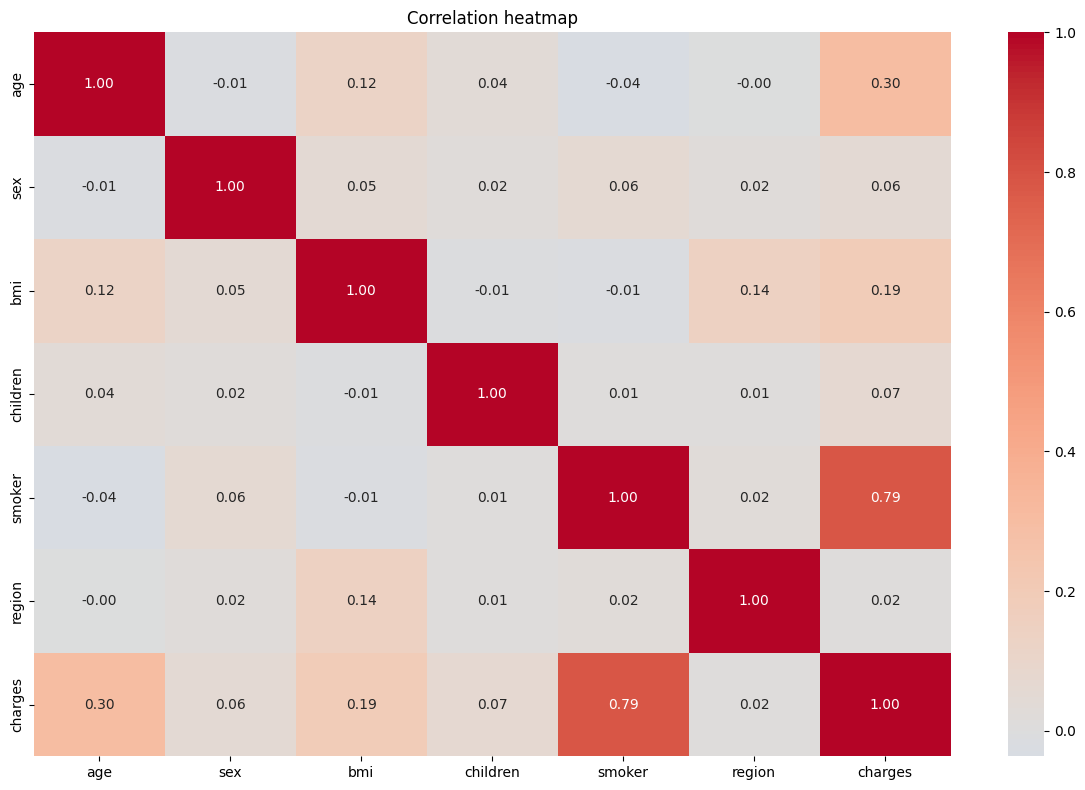

In [15]:
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation heatmap')
plt.tight_layout()
plt.show()

## 2. Многомерная линейная регрессия
Построить модель линейной регрессии и подобрать параметры:
1. аналитически (реализовать самому)
2. численно, с помощью методов градиентного спуска (реализовать самому)

## 3. Добавление регуляризации
Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса:
1. аналитически
2. численно

In [16]:
X_train = train.drop('charges', axis=1).values
y_train = train['charges'].values
X_test = test.drop('charges', axis=1).values
y_test = test['charges'].values

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
def analytical_solution(X, y, lambda_reg=0):
    X_with_bias = np.c_[np.ones(X.shape[0]), X]
    
    if lambda_reg > 0:
        reg = np.eye(X_with_bias.shape[1])
        reg[0, 0] = 0
        weights = np.linalg.inv(
            X_with_bias.T @ X_with_bias + lambda_reg * reg
        ) @ X_with_bias.T @ y
    else:
        weights = np.linalg.pinv(X_with_bias.T @ X_with_bias) @ X_with_bias.T @ y
    return weights

In [19]:
from numpy.linalg import norm

class LinearRegression:
    def __init__(self, learning_rate=0.01, n_iter=1000, lambda_reg=0, eps=1e-6):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.lambda_reg = lambda_reg
        self.weights = None
        self.bias = None
        self.loss_history = []
        self.eps = eps
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.random.rand(n_features)
        self.bias = 0
        
        for i in range(self.n_iter):
            y_pred = np.dot(X, self.weights) + self.bias

            dw = (2/n_samples) * np.dot(X.T, (y_pred - y))
            db = (2/n_samples) * np.sum(y_pred - y)
            
            if self.lambda_reg > 0:
                dw += 2 * self.lambda_reg * self.weights
            
            old_weights = self.weights.copy()
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            loss = np.mean((y_pred - y)**2)
            if self.lambda_reg > 0:
                loss += self.lambda_reg * np.sum(self.weights**2)
            self.loss_history.append(loss)
            
            if i % 200 == 0:
                print(f"Iteration {i}, Loss: {loss:.4f}")

            if norm(old_weights - self.weights) < self.eps:
                break
        
        return self.weights, self.bias
    
    def predict(self, X):
        if self.weights is None:
            raise ValueError("Модель не обучена")
        return np.dot(X, self.weights) + self.bias

In [20]:
weights_analytical = analytical_solution(X_train, y_train)
print(f"Weights: {weights_analytical}")

Weights: [12992.43766038  3653.03318062    20.61021257  1999.53994069
   567.77654219  9509.54221059  -337.1829492 ]


In [21]:
lr_gradient = LinearRegression(learning_rate=0.1, n_iter=1000)
weights_gd, bias_gd = lr_gradient.fit(X_train, y_train)
print(f"Weights: {weights_gd}")
print(f"Bias: {bias_gd}")

Iteration 0, Loss: 309394352.8556
Weights: [3653.03318193   20.61021421 1999.53993759  567.77654176 9509.54220897
 -337.18294673]
Bias: 12992.437659934974


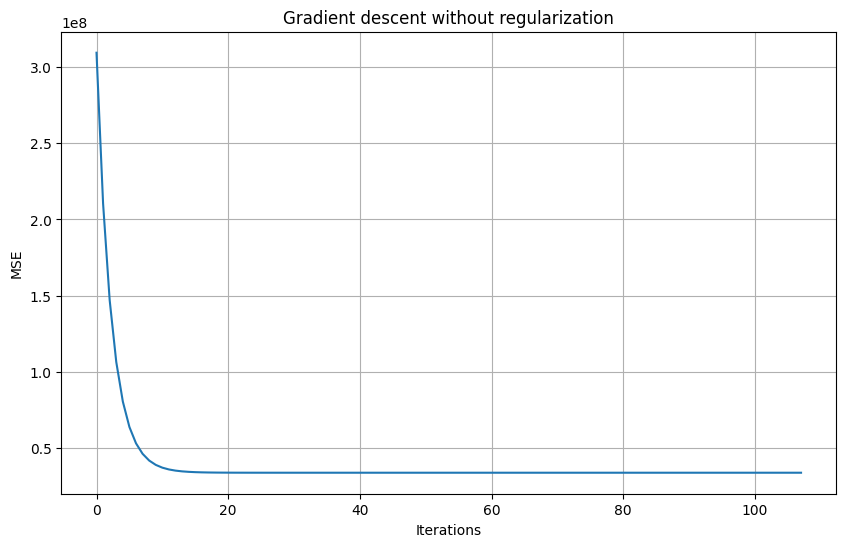

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(lr_gradient.loss_history)
plt.title('Gradient descent without regularization')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

In [23]:
weights_ridge_analytical = analytical_solution(X_train, y_train, lambda_reg=1.0)
print(f"Weights with regularization: {weights_ridge_analytical}")


Weights with regularization: [12992.43766038  3649.27250327    21.21225448  1997.71274821
   567.41163488  9499.82761553  -336.36386248]


In [24]:
lr_ridge_gradient = LinearRegression(learning_rate=0.1, n_iter=1000, lambda_reg=1.0)
weights_ridge_gd, bias_ridge_gd = lr_ridge_gradient.fit(X_train, y_train)
print(f"Weights with regularization: {weights_ridge_gd}")
print(f"Bias with regularization: {bias_ridge_gd}")

Iteration 0, Loss: 313661874.7786
Weights with regularization: [1801.55159208  167.28548501 1053.0536354   336.13751572 4707.70469506
  -44.27696271]
Bias with regularization: 12991.87175990679


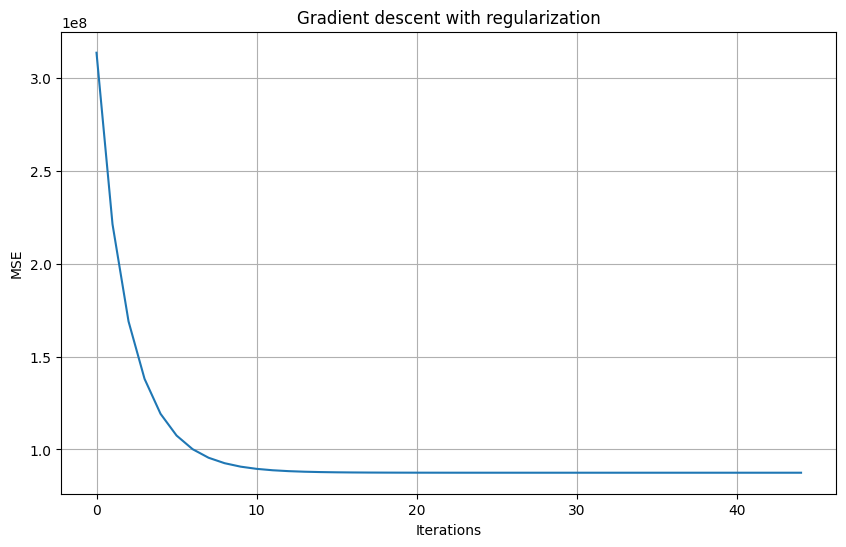

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(lr_ridge_gradient.loss_history)
plt.title('Gradient descent with regularization')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

In [26]:
def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def calculate_rmse(y_true, y_pred):
    return np.sqrt(calculate_mse(y_true, y_pred))

In [27]:
y_pred_constant = np.full_like(y_test, np.mean(y_train))
print(f"Constant MSE: {calculate_mse(y_test, y_pred_constant)}\nConstant RMSE: {calculate_rmse(y_test, y_pred_constant)}")

Constant MSE: 164374128.13344663
Constant RMSE: 12820.847403094955


In [28]:
X_test_with_bias = np.c_[np.ones(X_test.shape[0]), X_test]
y_pred_analytical = np.dot(X_test_with_bias, weights_analytical)
print(f"Analytical MSE: {calculate_mse(y_test, y_pred_analytical)}\nAnalytical RMSE: {calculate_rmse(y_test, y_pred_analytical)}")

Analytical MSE: 44759607.299307466
Analytical RMSE: 6690.26212485785


In [29]:
y_pred_gradient = lr_gradient.predict(X_test)
print(f"Gradient descent MSE: {calculate_mse(y_test, y_pred_gradient)}\nGradient descent RMSE: {calculate_rmse(y_test, y_pred_gradient)}")

Gradient descent MSE: 44759607.300904594
Gradient descent RMSE: 6690.262124977212


In [30]:
y_pred_ridge_analytical = np.dot(X_test_with_bias, weights_ridge_analytical)
print(f"Analytical with ridge MSE: {calculate_mse(y_test, y_pred_ridge_analytical)}\nAnalytical with ridge RMSE: {calculate_rmse(y_test, y_pred_ridge_analytical)}")

Analytical with ridge MSE: 44755797.36944074
Analytical with ridge RMSE: 6689.977381833271


In [31]:
y_pred_ridge_gradient = lr_ridge_gradient.predict(X_test)
print(f"Gradient descent with ridge MSE: {calculate_mse(y_test, y_pred_ridge_gradient)}\nGradient descent with ridge RMSE: {calculate_rmse(y_test, y_pred_ridge_gradient)}")

Gradient descent with ridge MSE: 74026680.19065234
Gradient descent with ridge RMSE: 8603.87588187163
